<h1 align="center" style="color: #6a287e;">Quantum Walk on a Line - Classiq</h1>

<h4 align="right" style="color: #7e587e;"><i>Assignment 6.12</i></h4>


<h4 style="color: #826d86; text-decoration: underline;">Classic Walk</h4>
<p style="color: #5f4f66; font-size: 16px;">A walk in the classical sense is a process that describes a path, considered as a summation of random steps. One type is a discrete walk, where the walker moves through a sequence of distinct positions, such as nodes on a graph, at each time step. At each step, the walker transitions to a neighboring position according to a specified probability distribution. For example, in a simple discrete random walk on a 1D line, a particle starting at position 0 can move one unit left or right with equal probability at each time step. </p>

<h4 style="color: #826d86; text-decoration: underline;">Quantum Walk</h4>
<p style="color: #5f4f66; font-size: 16px;">This is a quantum analogue of a classical random walk, where the quantum particle traverses a given graph with a specific topology, and quantum mechanics principles like superposition and interference influence the transitions. In the classical world, the particle can only move to one neighbouring state at a time, following a fixed path. In the quantum realm, however, the particle can be in a superposition of multiple states. A Discrete-Time Quantum Walk involves discrete time steps where the particle's position is updated using two operations: the coin operation and the shift operator, which will both be examined below. </p>


<h4 style="color: #826d86; text-decoration: underline;">Quantum Walk on Line Topology</h4>
<p style="color: #5f4f66; font-size: 16px;">In a line topology, the particle moves along a line where the nodes are arranged in a linear sequence. Initially, the particle is in the state ∣0⟩. At the first step, there is only one way to go: move right with probability 1. When the particle is in a position between the endpoints, it can move to the right or left with a probability of 0.5 each. If the particle is at the end of the line, it can only move left. This behavior defines the movement probabilities for the walk along the line.</p>

In [163]:
from classiq import *


In [164]:
size = 4 # 16 log2 is 4. 
tot_nodes = 2**size # this is necessary so I could iterate through all nodes of the line. 

@qfunc
# This function prepares a QBit in the ∣−⟩ state. 
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
# This oracle sets the auxiliary qubit based on whether the input x is non-zero, which is also a diffuser for Grover's search
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
# This function prepares an auxiliary qubit in the ∣−⟩ state and applies the diffuser oracle which inturn implements zero diffuser for quantum walk
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


<h4 style="color: #826d86; text-decoration: underline;">Coin Operator</h4>

<p style="color: #5f4f66; font-size: 16px;">The coin operator determines how the particle moves at each step by deciding the direction based on probabilities analogous to a classical coin flip. It creates a superposition of possible movements, allowing the particle to be in a state where it can move to the left or the right. Specifically, the coin operator influences the particle’s movement direction according to the probabilities defined, ensuring that the particle’s position evolves based on a combination of quantum superposition and classical-like probabilistic decisions.</p>

In [165]:
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):

    # Below is the coin operator which is used for quantum walk
    
    prob = [0]*tot_nodes  # An array with size 16
    if i == 0:
        prob[i + 1] = 1.0  # Initially, can only move to the right 
    elif i == tot_nodes - 1:
        prob[i - 1] = 1.0  # In the end can only move to the left 
    else:
        prob[i - 1] = 0.5  # if it is in between can move left with prob 1/2
        prob[i + 1] = 0.5  # and to the right with prob 1/2
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 

# This operator applies the Quantum Walk defined above to all the vertices!

def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i,vertices,adjacent_vertices)



<h4 style="color: #826d86; text-decoration: underline;">Shift Operator</h4>

<p style="color: #5f4f66; font-size: 16px;">Once the movement probabilities are defined, the next step is the shift operator. This operator adjusts the quantum particle''s state based on the direction probabilities determined by the coin operator. It shifts the particle to the new positions, reflecting the movement. During this process, quantum constructive or destructive interference can occur, where the probability amplitudes of different paths combine, either enhancing or diminishing the likelihood of various outcomes depending on the movement direction.</p>




In [167]:
@qfunc

# This makes sure if there is an edge between two vertices/nodes, or in other words if the two nodes are connected 
# as Steps in a walk can only happen on these edges. 

def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc 

# This shifts/ changes the state of the two states by swapping their QArray's bit by bit.

def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 

# First sees if two vertices are adjacent with the edge oracle. 
# Then using the bitwise_swap, the states of the vertices gets swapped with adjacent vertices bt by bit

def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))


<h4 style="color: #826d86; text-decoration: underline;">Now the main function</h4>

<p style="color: #5f4f66; font-size: 16px;">This just puts everything together. First, we initialize the qubits. Next, we apply the Hadamard transform to put all the vertices into a superposition. We then apply the coin operator to determine the direction of movement, followed by the shift operator to update the particle's position based on the probabilities. Finally, we synthesize and display the quantum walk program.</p>




In [160]:

@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

python(217) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<h4 style="color: #826d86; text-decoration: underline;">Below is the circuit</h4>

<p style="color: #5f4f66; font-size: 16px;">This is the general circuit without looking at the coin operator and the shift operator in detail. </p>



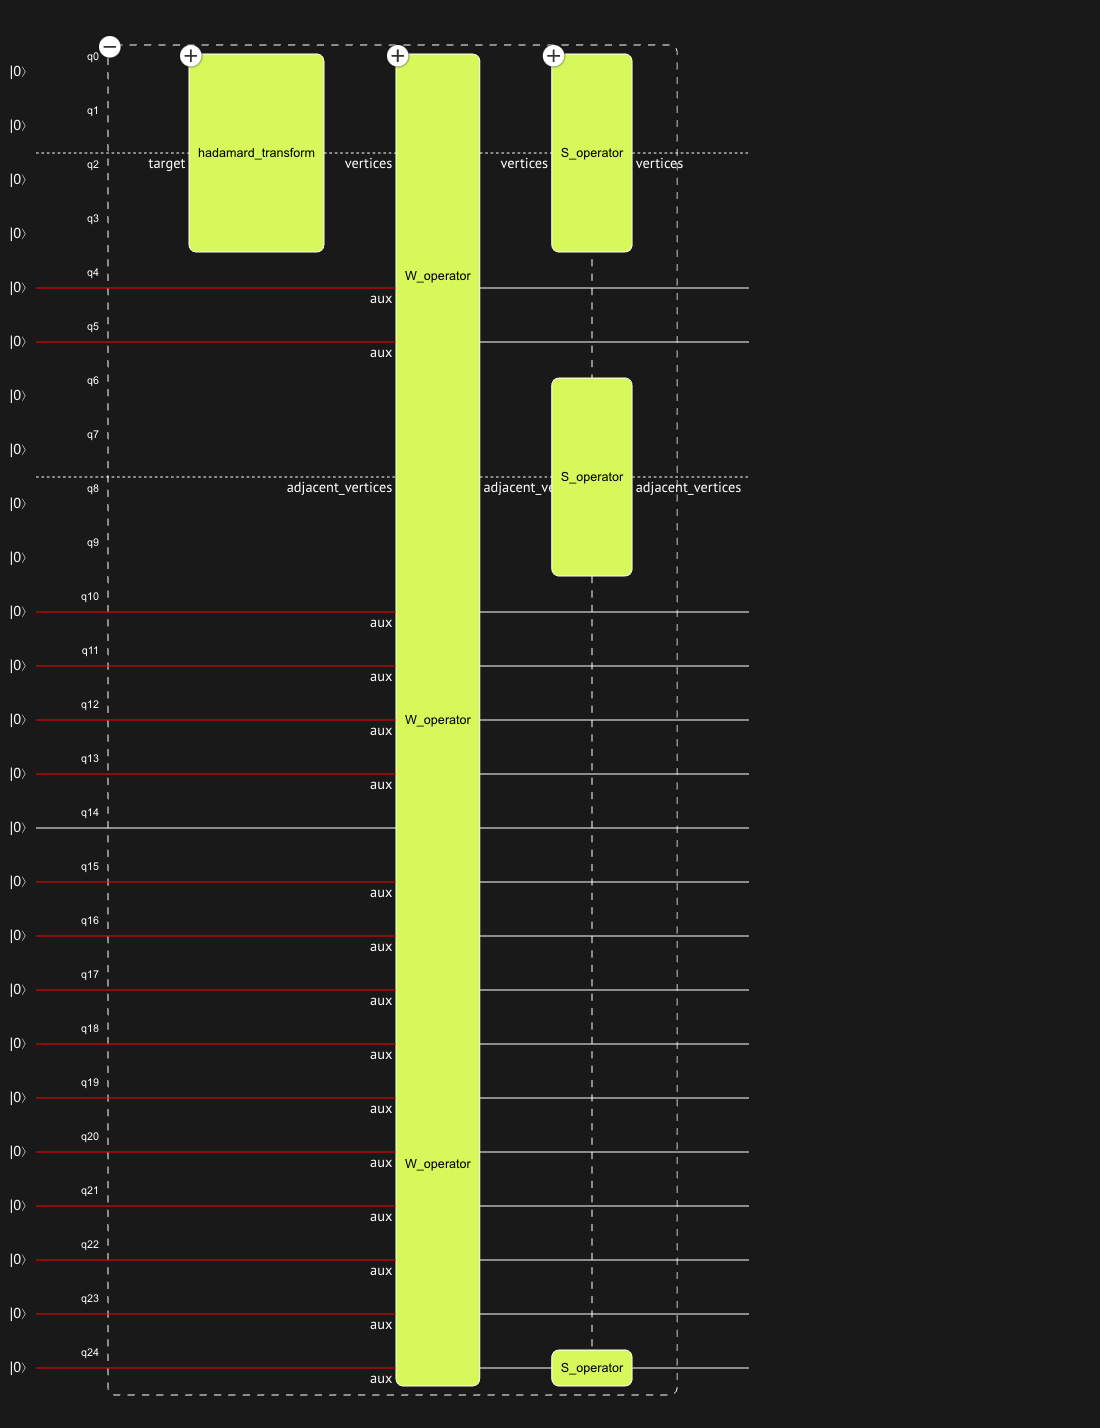

<p style="color: #5f4f66; font-size: 16px;">There are three stages, first, the Hadamard transform, then the coin operator and the shift operator. A Hadamard transform is applied to make sure everything or all the states are in superposition. Below, the coin operator and the shift operator is explained in more detail.</p>


<h4 style="color: #826d86; text-decoration: underline;">Coin operator.</h4>

<p style="color: #5f4f66; font-size: 16px;">Below, we see the coin operator in much more detail. As is too big, all of it can't fit here so below is the beginning of the operator and the end of the operator.</p>



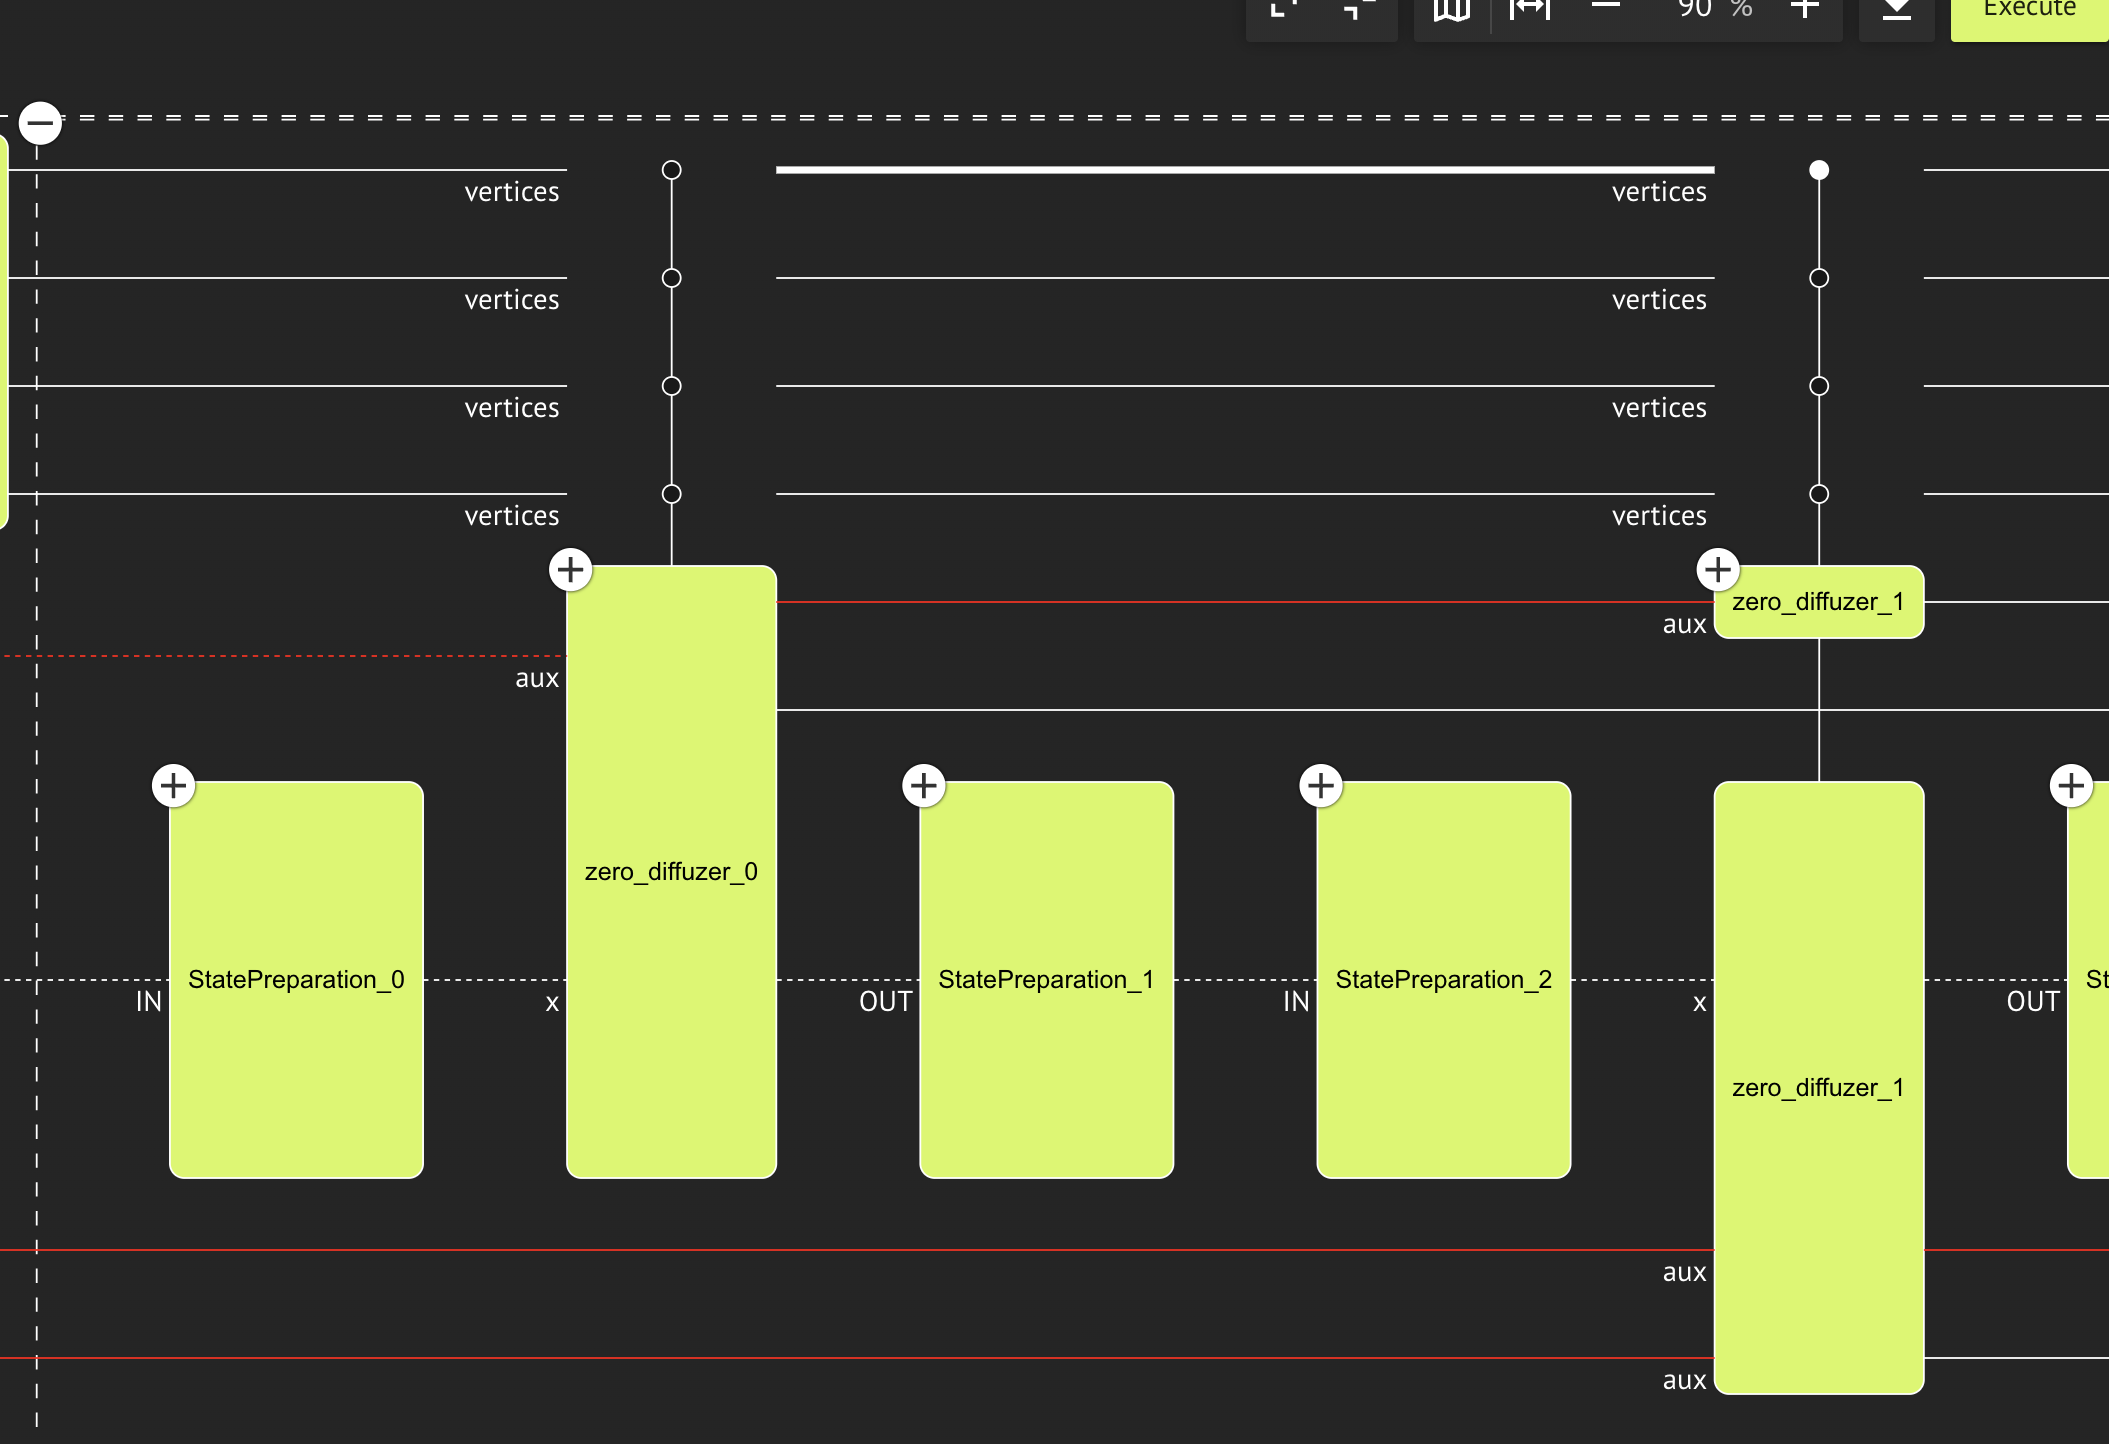

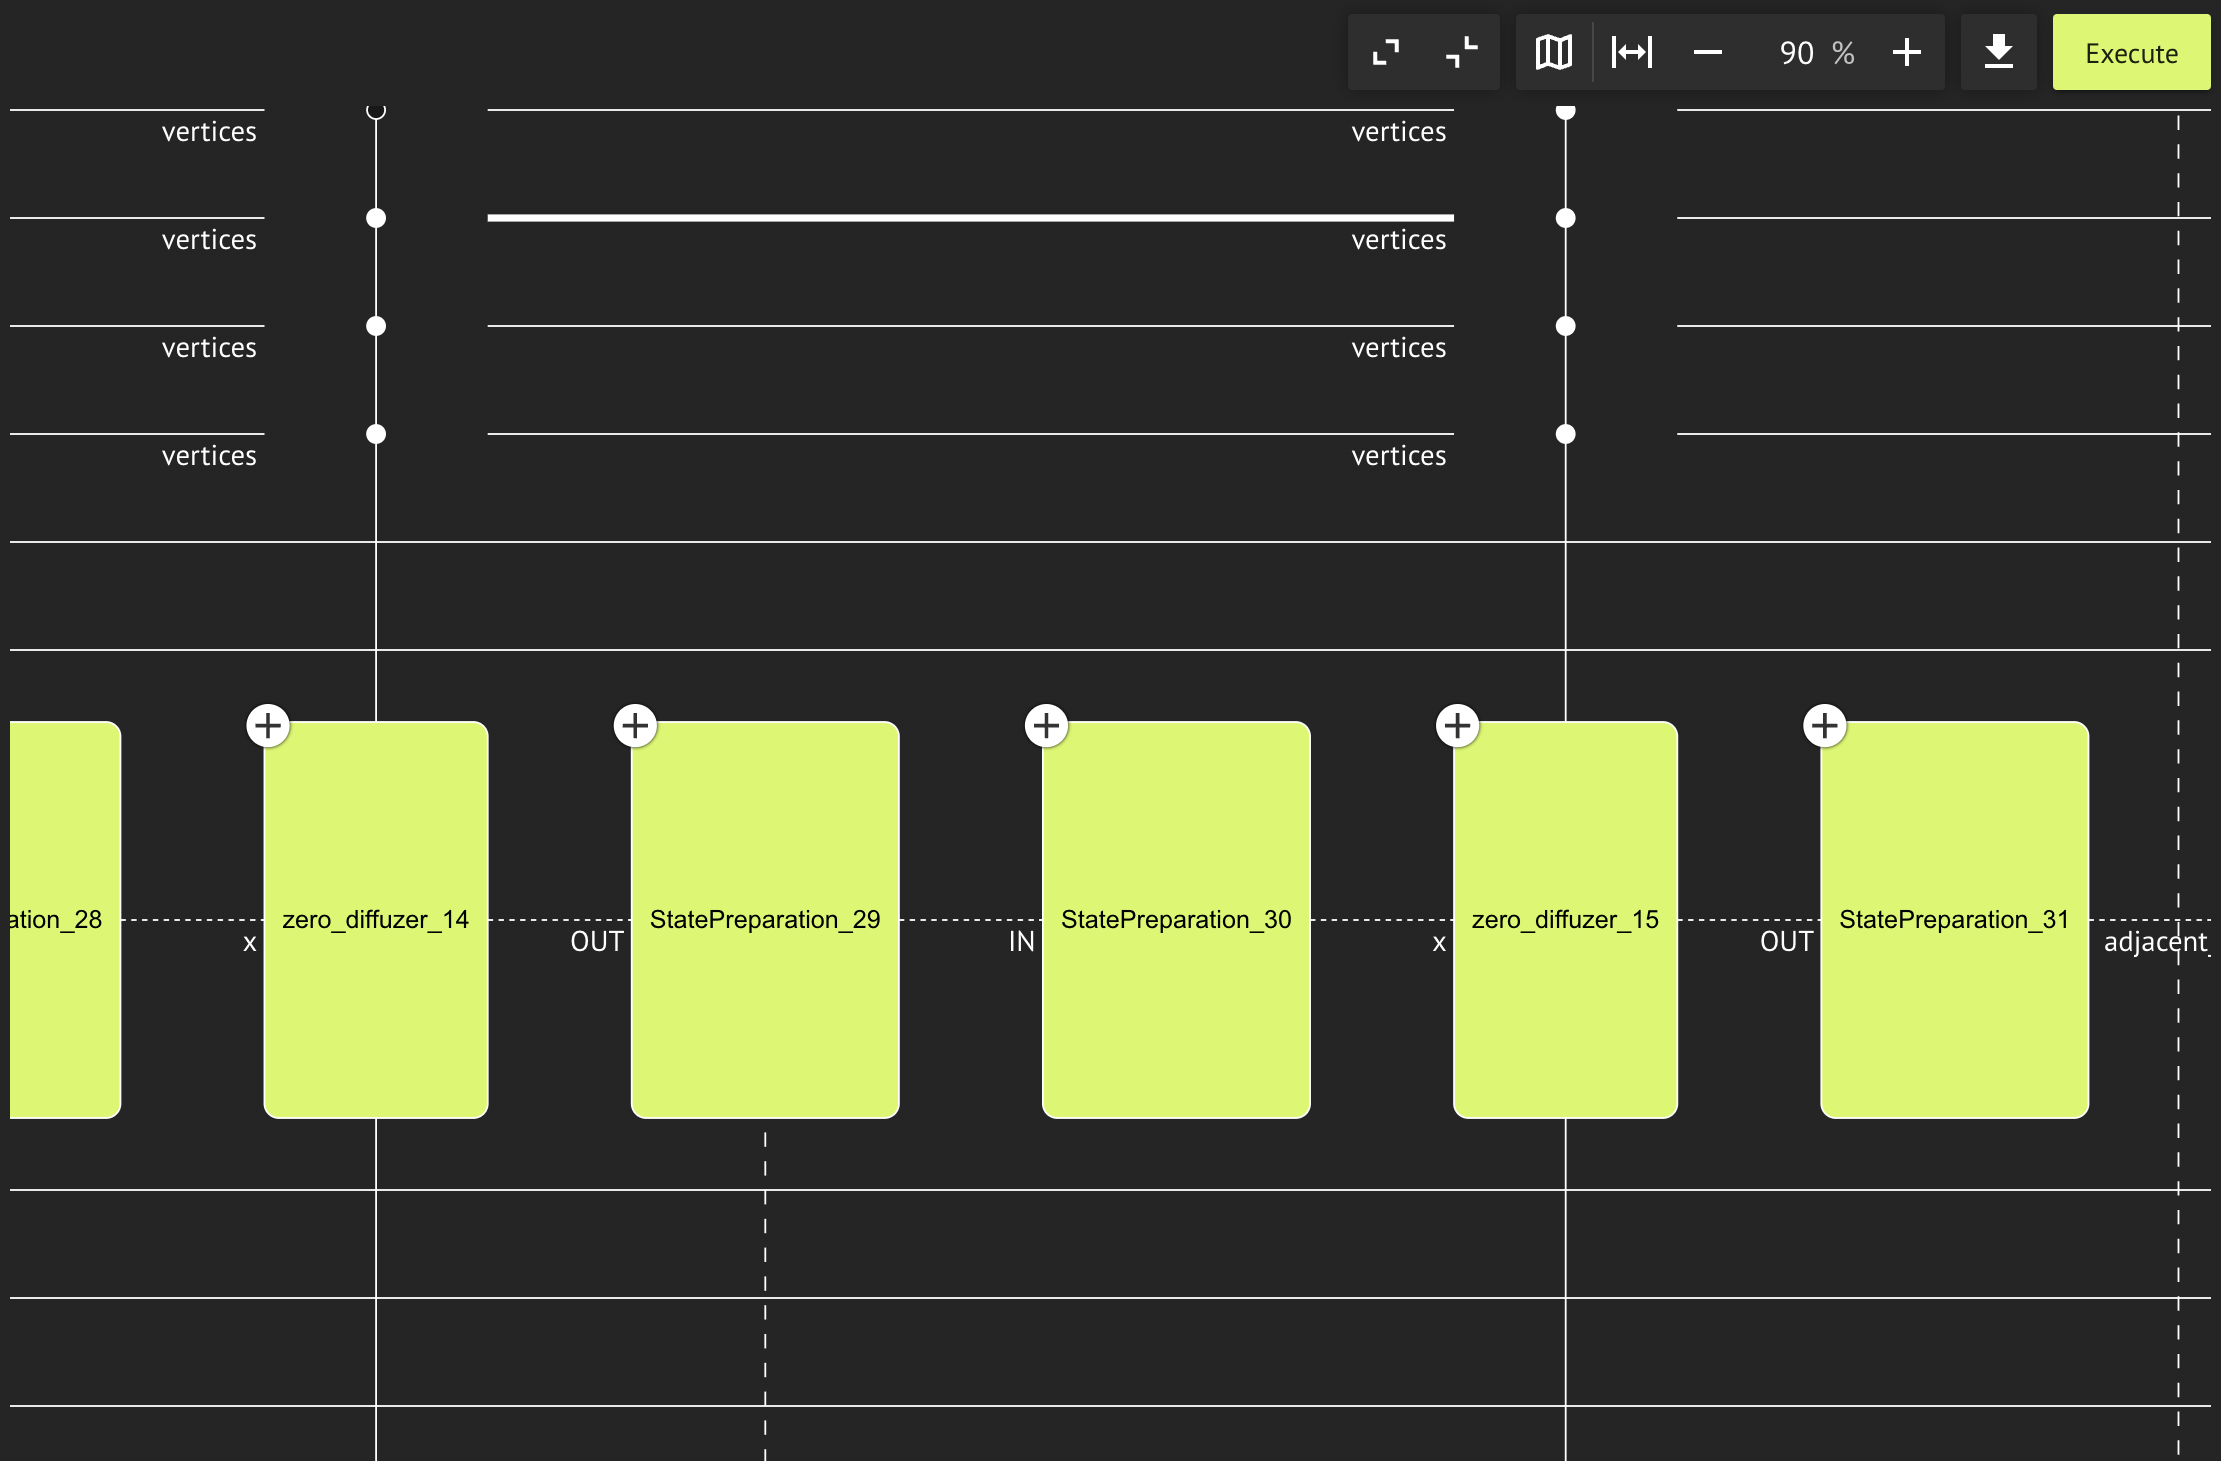


<p style="color: #5f4f66; font-size: 16px;">As we can see, in the beginning, there is one State Prepare operator and zero diffusion operator. Then after that, there are two State preparation and operators and one zero diffuser and it ends with the state prepare operator. This is because in the beginning and the end, there is only one state to go to from where we are but otherwise, there are two possible states. And the diffuser state basically diffuses the particle throughout every state making sure the probabilities across are distributed equally.</p>



<h4 style="color: #826d86; text-decoration: underline;">State operator.</h4>

<p style="color: #5f4f66; font-size: 16px;">Below, we can see what's happening in the state operator in more detail. </p>


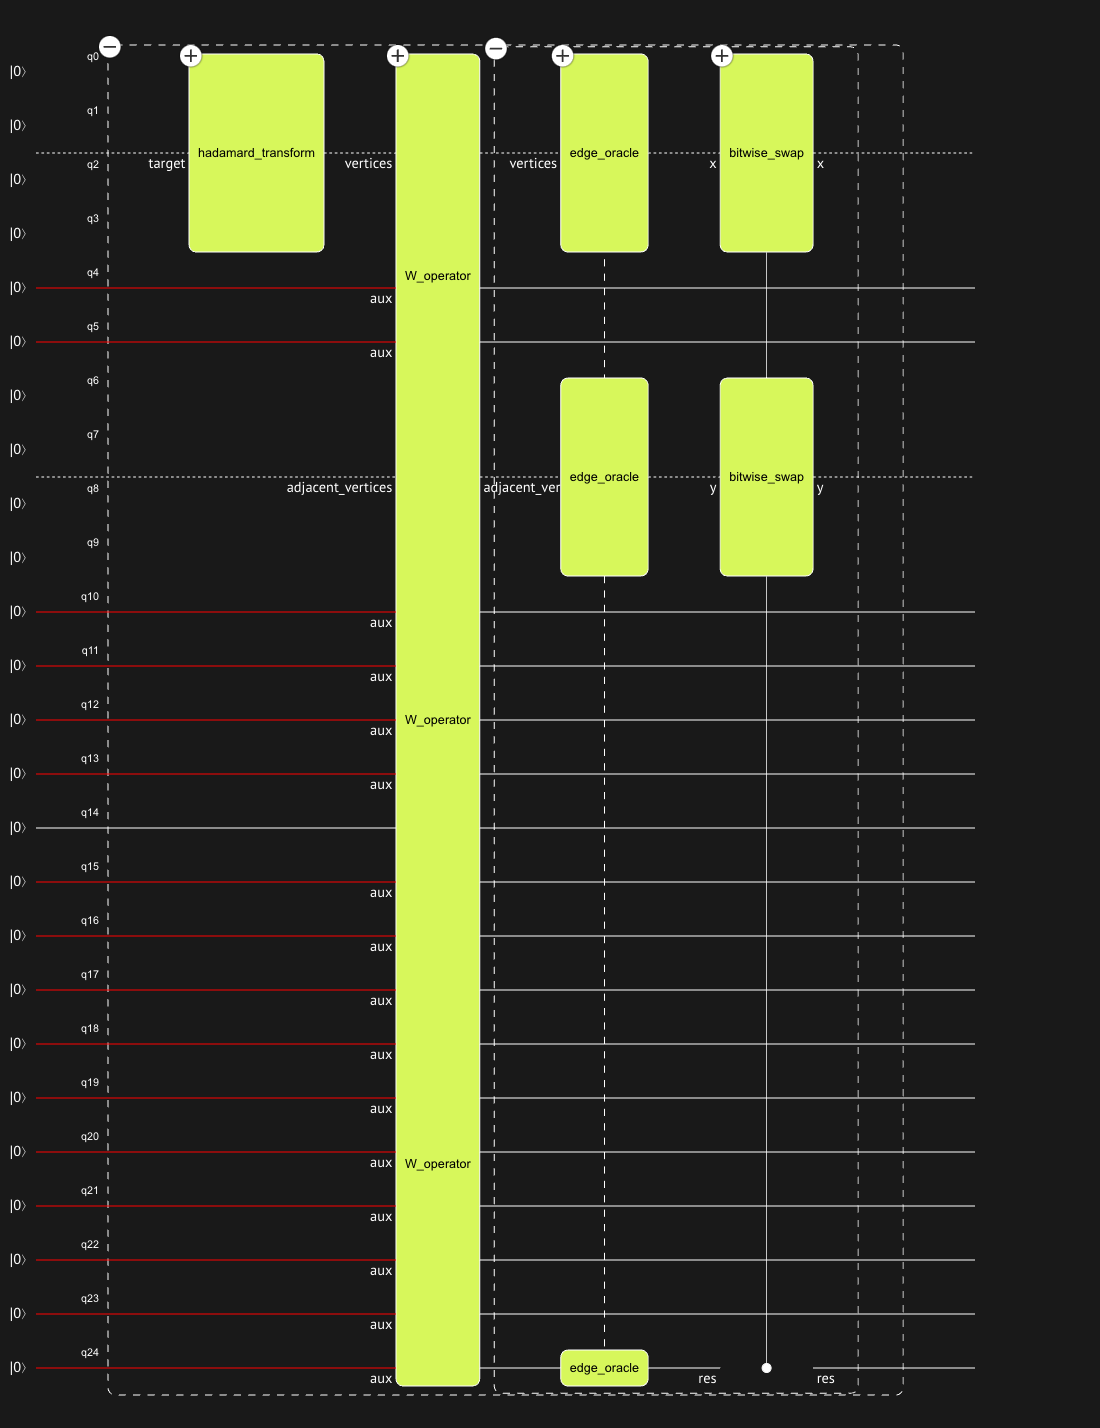

<p style="color: #5f4f66; font-size: 16px;">By now, what we have are all the states in superposition and then we applied the coin operator. Now is the shift operator and in that first, we apply the edge oracle to see if the current vertice has any adjacent vertices which will result in an edge. After finding the adjacent vertices, the states of these are shifted, or exchanged bit by bit; this only happens if there are any adjacent vertices. This further makes the quantum walk happen, as the state of the particle is moving throughout!</p>

<h4 style="color: #826d86; text-decoration: underline;">Results</h4>

<p style="color: #5f4f66; font-size: 16px;">After synthesizing and executing in the IDE, I got the below graph and it can be seen that the probability of each state is around 0.63</p>


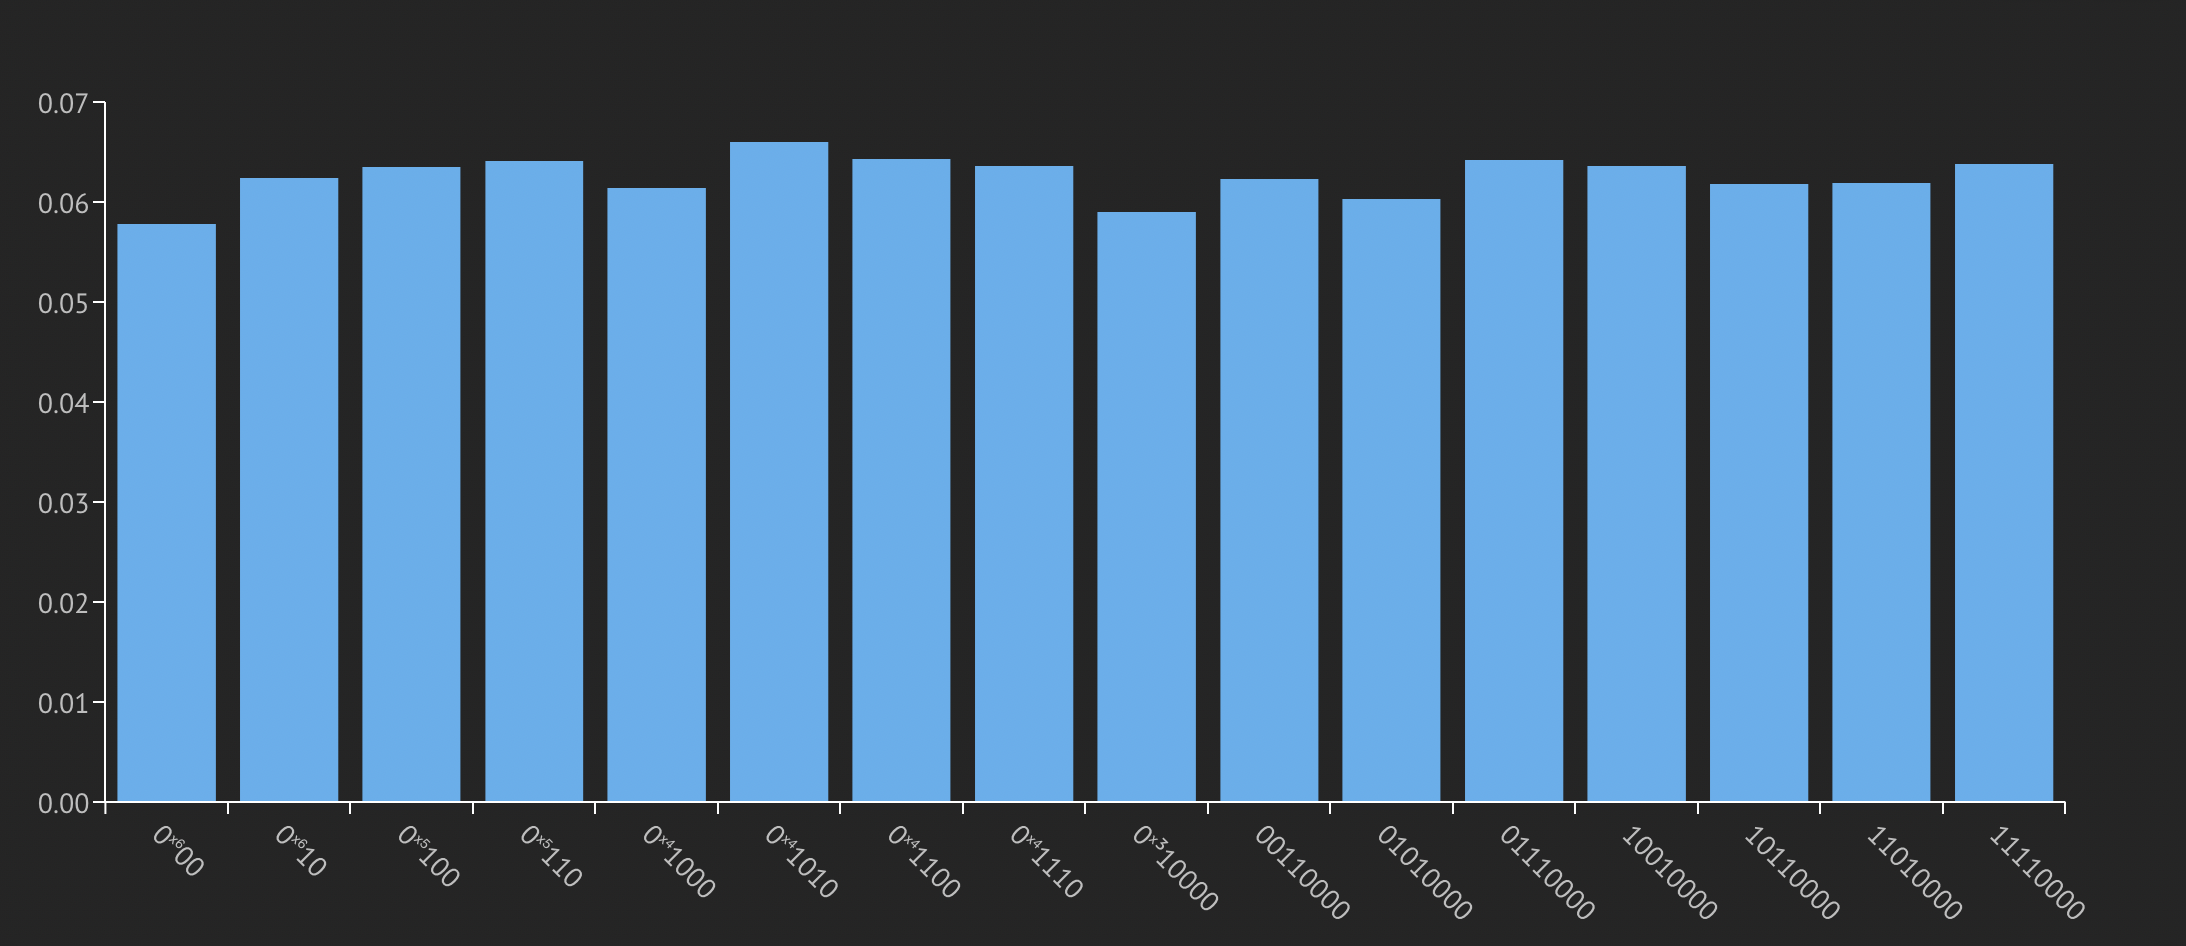